<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-итог" data-toc-modified-id="Промежуточный-итог-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Промежуточный итог</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Промежуточные-выводы" data-toc-modified-id="Промежуточные-выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Промежуточные выводы</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Первым делом загрузим необходимые для работы библиотеки и данные.

In [1]:
#Стандартные библиотеки для анализа данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#NLP библиотеки для подготовки данных 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
wnl = WordNetLemmatizer()

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
#Построение пайплайнов для обучения моделей
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
#Модели участвующие в отборе и метрика для проверки
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
#Константы и настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 1

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aleks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загрузим данные, указав первым столбцом индексы.

In [2]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col='Unnamed: 0')
except:
    data = pd.read_csv('C:/Users/Aleks/Desktop/Мага/Яндекс/Проект по NLP/toxic_comments.csv', index_col='Unnamed: 0')

Проведем первичный анализ данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
data.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Данные соответсвую описанию и не содержат каких-то явных серьезных проблем. Посмотрим наличие дубликатов и пропусков в данных.

In [5]:
f"Число пропусков в сообщениях - {data['text'].isna().sum()}"

'Число пропусков в сообщениях - 0'

In [6]:
f"Число дубликатов в сообщениях - {data['text'].duplicated().sum()}"

'Число дубликатов в сообщениях - 0'

Как видно в данных нет ни пропусков, ни дубликатов, что не может не радовать. Проанализируем единственный доступный числовой параметр toxic.

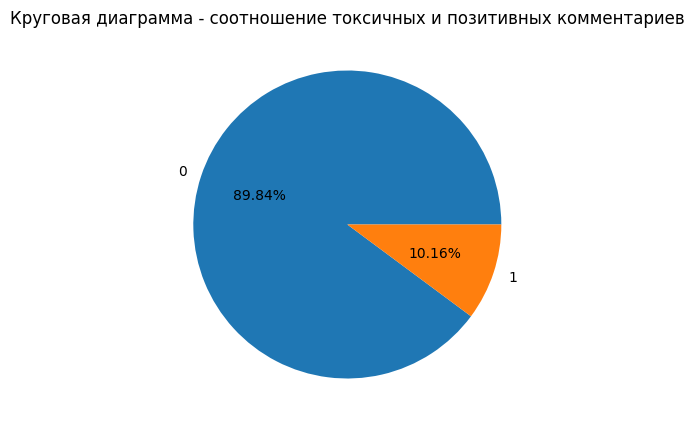

In [7]:
plt.figure(figsize= (5, 5))
plt.pie(data['toxic'].value_counts(), autopct = lambda x: '%.2f' % x + '%', labels=data['toxic'].value_counts().index)
plt.title('Круговая диаграмма - соотношение токсичных и позитивных комментариев')
plt.show()

На лицо дисбаланс классов - это важно будет учесть, при разделении данных на выборки, указав параметр stratify.

Далле присутствует тщетная попытка реализовать схему эмбендингов с BERT. Понял что мой ПК не потянет такую задачу - 27 часов на построение всех признаков, а потом еще больше на обучение моделей. Возможно где-то у меня есть здесь ошибка.

In [8]:
'''

import torch
import transformers
from tqdm import notebook 

tokenizer = transformers.BertTokenizer(
    vocab_file="C:/Users/Aleks/Desktop/Мага/Яндекс/BERT/vocab.txt")

after_tokenaizer = data['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

after_tokenaizer = after_tokenaizer[after_tokenaizer.agg(func=len) <= 512]

max_len = max(after_tokenaizer.agg(func=len))

padded = np.array([i + [0]*(max_len - len(i)) for i in after_tokenaizer.values])

attention_mask = np.where(padded != 0, 1, 0)

config = transformers.BertConfig.from_json_file(
    'C:/Users/Aleks/Desktop/Мага/Яндекс/BERT/config.json')

model = transformers.BertModel.from_pretrained(
    'C:/Users/Aleks/Desktop/Мага/Яндекс/BERT/pytorch_model.bin', config=config)

batch_size = 150
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
        
features = np.concatenate(embeddings)
27 часов на все💀
'''

'\n\nimport torch\nimport transformers\nfrom tqdm import notebook \n\ntokenizer = transformers.BertTokenizer(\n    vocab_file="C:/Users/Aleks/Desktop/Мага/Яндекс/BERT/vocab.txt")\n\nafter_tokenaizer = data[\'text\'].apply(\n    lambda x: tokenizer.encode(x, add_special_tokens=True))\n\nafter_tokenaizer = after_tokenaizer[after_tokenaizer.agg(func=len) <= 512]\n\nmax_len = max(after_tokenaizer.agg(func=len))\n\npadded = np.array([i + [0]*(max_len - len(i)) for i in after_tokenaizer.values])\n\nattention_mask = np.where(padded != 0, 1, 0)\n\nconfig = transformers.BertConfig.from_json_file(\n    \'C:/Users/Aleks/Desktop/Мага/Яндекс/BERT/config.json\')\n\nmodel = transformers.BertModel.from_pretrained(\n    \'C:/Users/Aleks/Desktop/Мага/Яндекс/BERT/pytorch_model.bin\', config=config)\n\nbatch_size = 150\nembeddings = []\nfor i in notebook.tqdm(range(padded.shape[0] // batch_size)):\n        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) \n        attention_mask_batch = tor

Приступим к подготовке данных для обучения. Подготовка будет состоять из двух этапов:
1. Лемматизации текста сообщения - приведение слов к первоначальному виду
2. Очистка текста от ненужных символов

Реализуится данные шаги через создание функций с соответствующими библиотеками и последующим применением их к каждому элементу таблицы. 

In [9]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

def clear_text(text):
    
    return " ".join( re.sub(r'[^a-zA-Z ]', ' ', text).split() )

data_prep =[]

for i in data.index:
    sentence = data.loc[i, 'text'].lower()
    tokens = word_tokenize(sentence)
    tagged = pos_tag(tokens)
    
    lemmatized_words = []
    for word, tag in tagged:
        wordnet_tag = get_wordnet_pos(tag)
        lemma = wnl.lemmatize(word, pos=wordnet_tag)
        lemmatized_words.append(lemma)    
   
    data_prep.append(' '.join(lemmatized_words))

for i in range(len(data_prep)):
    data_prep[i] = clear_text(data_prep[i])

data_prep = pd.DataFrame(data_prep, columns = ['corpus'])

data_prep

,corpus
0,explanation why the edits make under my username hardcore metallica fan be revert they be n t vandalisms just closure on some gas after i vote at new york doll fac and please do n t remove the template from the talk page since i m retired now
1,d aww he match this background colour i m seemingly stick with thanks talk january utc
2,hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the formatting than the actual info
3,more i ca n t make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it s list in the relevant form eg wikipedia good article nominations transport
4,you sir be my hero any chance you remember what page that s on
...,...
159287,and for the second time of ask when your view completely contradict the coverage in reliable source why should anyone care what you feel you ca n t even give a consistent argument be the open only suppose to mention significant aspect or the most significant one
159288,you should be ashamed of yourself that be a horrible thing you put on my talk page
159289,spitzer umm theres no actual article for prostitution ring crunch captain
159290,and it look like it be actually you who put on the speedy to have the first version delete now that i look at it


Мы подготовили данные к обучению моделей, теперь разобьем их на тренировочную и тестовую выборки в соотношении 8:2, указав при этом параметр stratify=data['toxic'].

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    data_prep,
    data['toxic'],
    test_size= 0.20,
    stratify = data['toxic'],
    random_state=RANDOM_STATE)

### Промежуточный итог

1. Загружены основные библиотеки
2. Загружены данные и проверены на соответсвие требованиям
3. Данные подготовлины и разделены на выборки

## Обучение

Переходим к этапу построению пайплайнов. Всю предобработку и построение пайплайнов реализованно внутри функции, в которую будет передоваться одна модель и параметры для подбора в связи с крайне длительным процессом обучения.

In [11]:
def model_pipeline_search(
    X_train, 
    y_train, 
    model, 
    params
):
    data_preprocessor = ColumnTransformer(
    [
        ('tfidf', TfidfVectorizer(stop_words = stopwords), 'corpus') # Указываем параметр stop_words, для удаления бессмысленных слов
    ], 
    remainder='passthrough')
    
    pipeline = Pipeline([
        ('vect', data_preprocessor),
        ('clf', model)
    ])
    
    grid = GridSearchCV(
        pipeline, 
        params, 
        cv=5,
        n_jobs=1,
        scoring='f1', # Метрика f1 по ТЗ
        error_score= 0.1
    ) 
    
    grid.fit(X_train, y_train)
    #Также выведем таблицу с результатами для анализа проведенного обучения
    res = pd.DataFrame(grid.cv_results_)[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score')

    return grid, res

Функция для обучения готова, переходим к обучению.

In [12]:
params = [{
    'vect__tfidf__ngram_range': ((1, 2), (1, 3)),
    'vect__tfidf__max_features': (10000, 5000),
    'clf__C': (0.7, 0.9),
    'clf__penalty': ('none', 'l2')
}]

data_grids_log_reg, table_log_reg = model_pipeline_search(
    X_train, 
    y_train, 
    LogisticRegression(max_iter=1000, random_state=RANDOM_STATE), 
    params)

C:\Users\Aleks\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Aleks\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Aleks\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\Aleks\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_logis

In [13]:
table_log_reg

,rank_test_score,mean_test_score,params
3,1,0.744130,"{'clf__C': 0.7, 'clf__penalty': 'none', 'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 3)}"
11,1,0.744130,"{'clf__C': 0.9, 'clf__penalty': 'none', 'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 3)}"
2,3,0.742422,"{'clf__C': 0.7, 'clf__penalty': 'none', 'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 2)}"
10,3,0.742422,"{'clf__C': 0.9, 'clf__penalty': 'none', 'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 2)}"
13,5,0.727721,"{'clf__C': 0.9, 'clf__penalty': 'l2', 'vect__tfidf__max_features': 10000, 'vect__tfidf__ngram_range': (1, 3)}"
14,6,0.727028,"{'clf__C': 0.9, 'clf__penalty': 'l2', 'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 2)}"
12,7,0.726404,"{'clf__C': 0.9, 'clf__penalty': 'l2', 'vect__tfidf__max_features': 10000, 'vect__tfidf__ngram_range': (1, 2)}"
15,8,0.724355,"{'clf__C': 0.9, 'clf__penalty': 'l2', 'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 3)}"
6,9,0.717000,"{'clf__C': 0.7, 'clf__penalty': 'l2', 'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 2)}"
7,10,0.715866,"{'clf__C': 0.7, 'clf__penalty': 'l2', 'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 3)}"


Обучение логистической регрессии заняло около 10 минут и в результате мы видим, что при уменьшении максимального числа признаков TfidfVectorizer метрика растет, но не достигает требуемых 0.75.

In [14]:
params = [{
    'vect__tfidf__ngram_range': ((1, 2), (1, 1)),
    'vect__tfidf__max_features':(3000, 5000)
}]

data_grids_tree, table_tree = model_pipeline_search(
    X_train, 
    y_train, 
    DecisionTreeClassifier(random_state=RANDOM_STATE), 
    params)

In [15]:
table_tree

,rank_test_score,mean_test_score,params
3,1,0.690193,"{'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 1)}"
1,2,0.680607,"{'vect__tfidf__max_features': 3000, 'vect__tfidf__ngram_range': (1, 1)}"
2,3,0.680545,"{'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 2)}"
0,4,0.669657,"{'vect__tfidf__max_features': 3000, 'vect__tfidf__ngram_range': (1, 2)}"


Данная модель обучалась 15, также заметно что DecisionTreeClassifier чуствует себя чуть лучше с униграммами, но метрика тоже не достигает необходимых значений.

In [16]:
params = [{
    'vect__tfidf__ngram_range': ((1, 1), (1, 2)),
    'vect__tfidf__max_features':(8000, 5000)
}]

data_grids_forest, table_forest = model_pipeline_search(
    X_train, 
    y_train, 
    RandomForestClassifier(random_state=RANDOM_STATE), 
    params)

In [17]:
table_forest

,rank_test_score,mean_test_score,params
0,1,0.750326,"{'vect__tfidf__max_features': 8000, 'vect__tfidf__ngram_range': (1, 1)}"
2,2,0.749422,"{'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 1)}"
1,3,0.747260,"{'vect__tfidf__max_features': 8000, 'vect__tfidf__ngram_range': (1, 2)}"
3,4,0.741051,"{'vect__tfidf__max_features': 5000, 'vect__tfidf__ngram_range': (1, 2)}"


Как и предыдущая модель RandomForestClassifier обучалась около 1 часа, но при этом ей удалось достичь необходимых значений. Можно было бы попробывать еще улучшить значение метрики увеличив max_features и n грамму. 

Наилучшим образом при обучении себя показала RandomForestClassifier, поэтому и выбираем эту модель как лучшую. Протестируем ее на тестовых данных.

In [18]:
features = data_grids_forest.best_estimator_['vect'].transform(X_test)

result_test = data_grids_forest.best_estimator_['clf'].predict(features)

In [19]:
print(f'Метрика f1 для модели RandomForestClassifier на тестовой выборке - {f1_score(y_test, result_test)}')

Метрика f1 для модели RandomForestClassifier на тестовой выборке - 0.7558423439134985


Лучшая модель подтвердила свой результат и требуемое по ТЗ значение метрики достигнуто.

### Промежуточные выводы

1. Составлена функция с пайплайном для обучения моделей
2. Были обучены LogisticRegression, DecisionTreeClassifier, RandomForestClassifier с различными параметрами TfidfVectorizer
3. Лучшим образом себя показала RandomForestClassifier с значением метрики чуть больше 0.75 и потом подтвердив его на тестовой выборке

## Выводы

Была обучена модель RandomForestClassifier с необходимым значением метрики f1, для этого мы загрузили данные и предобработали их. Можно было бы в будущем улучшить результат модели увеличив max_features и n-грамму или попробывав реализовав схему эмбендингов с BERT.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны